In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from ipywidgets import IntProgress
from IPython.display import display

In [4]:
from model_size_calculator import ModelSizeCalculator

In [5]:
import json

In [6]:
from var_table import VarTable

In [7]:
var_table = VarTable()

In [8]:
M = 10 ** 10

In [9]:
df = pd.read_csv('dataset.csv')

In [10]:
experiments_number = len(df)
experiments_subnumber = 10

In [11]:
config = {}

In [12]:
solvers = ['glpk', 'cbc', 'genetic#1', 'genetic#2', 'genetic#3', 'random']

In [13]:
fitnesses_dataset = {}
durations_dataset = {}

In [14]:
# fitness
for solver in solvers:
    fitnesses_dataset[solver] = []

In [15]:
# duration
for solver in solvers[:-1]:
    durations_dataset[solver] = []

In [16]:
fitnesses_dataset['variables'] = []
fitnesses_dataset['constraints'] = []
fitnesses_dataset['number'] = []
fitnesses_dataset['subnumber'] = []

In [17]:
def find_data_by_name(dataset, name):
    for data in dataset:
        data_name = data['name']
        if data_name == name:
            return data

In [18]:
def find_solution_by_config(solutions, config):
    for solution in solutions:
        solution_config = solution['config']
        if solution_config == config:
            return solution

In [19]:
def draw_durations_plot(df):
    plt.title('durations')
    plt.xlabel('experiment')
    plt.ylabel('duration, sec')
    sns.lineplot(data=df)

In [20]:
# Переделать в комплекс круговых диаграмм
def draw_relative_fitnesses_polt(df):
    df_melted = pd.melt(df)
    title = 'fitnesses'
    sns.violinplot(x='variable', y='value', data=df_melted, width=0.7, dodge=False, hue='variable').set(title=title)
    plt.xlabel('solver')
    plt.xticks(rotation=75)
    plt.ylabel('random fitness / fitness')

In [21]:
# fitness
for experiment_number in range(experiments_number):
    for experiment_subnumber in range(experiments_subnumber):
        nested_directory = var_table.get_nested_directory(experiment_number, experiment_subnumber)
        file_path = '{}/solutions.json'.format(nested_directory)
        file = open(file_path, 'r')
        content = file.read()
        dataset = json.loads(content)
        file.close()
        for solver in solvers:
            data = find_data_by_name(dataset, solver)
            solutions = data['solutions']
            solution = find_solution_by_config(solutions, config)
            result = solution['result']
            fitness = result['fitness']
            fitnesses_dataset[solver].append(fitness)

In [22]:
# duration
for experiment_number in range(experiments_number):
    for solver in solvers[:-1]:
        duration_values = []
        for experiment_subnumber in range(experiments_subnumber):
            nested_directory = var_table.get_nested_directory(experiment_number, experiment_subnumber)
            file_path = '{}/solutions.json'.format(nested_directory)
            file = open(file_path, 'r')
            content = file.read()
            dataset = json.loads(content)
            file.close()
            data = find_data_by_name(dataset, solver)
            solutions = data['solutions']
            solution = find_solution_by_config(solutions, config)
            result = solution['result']
            duration = result['duration']
            duration_values.append(duration)
        mean_duration = sum(duration_values) / len(duration_values)
        durations_dataset[solver].append(mean_duration)

In [23]:
progress = IntProgress(min=0, max=experiments_number * experiments_subnumber, value=0, description='progress', bar_style='success')
display(progress)
for experiment_number in range(experiments_number):
    for experiment_subnumber in range(experiments_subnumber):
        k = df['k'][experiment_number]
        l = df['l'][experiment_number]
        m = df['m'][experiment_number]
        n = df['n'][experiment_number]
    
        model_size_calculator = ModelSizeCalculator(k, l, m, n)
        
        variables_count = model_size_calculator.calculate_variables_count()
        constraints_count = model_size_calculator.calculate_constraints_count()
        fitnesses_dataset['variables'].append(variables_count)
        fitnesses_dataset['constraints'].append(constraints_count)
        fitnesses_dataset['number'].append(experiment_number)
        fitnesses_dataset['subnumber'].append(experiment_subnumber)
        progress.value += 1

IntProgress(value=0, bar_style='success', description='progress', max=1930)

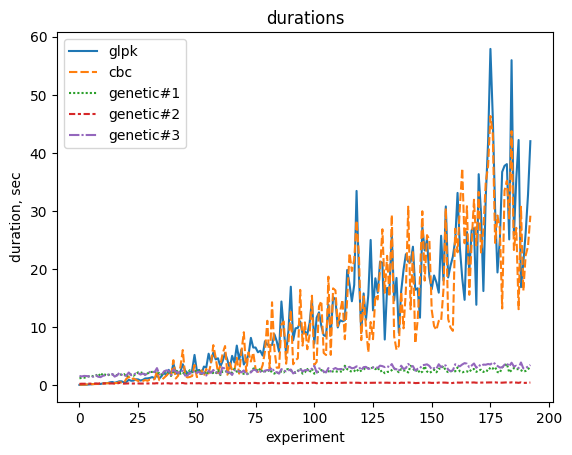

In [24]:
durations_df = pd.DataFrame(durations_dataset)
draw_durations_plot(durations_df)

In [25]:
polyfit_durations_df = pd.DataFrame()
for solver in solvers[:-1]:
    index = [i for i in durations_df.index]
    values = durations_dataset[solver]
    fp, residuals, rank, sv, rcond = np.polyfit(index, values, 2, full=True)
    f = np.poly1d(fp)
    polyfit_durations_df[solver] = f(index)

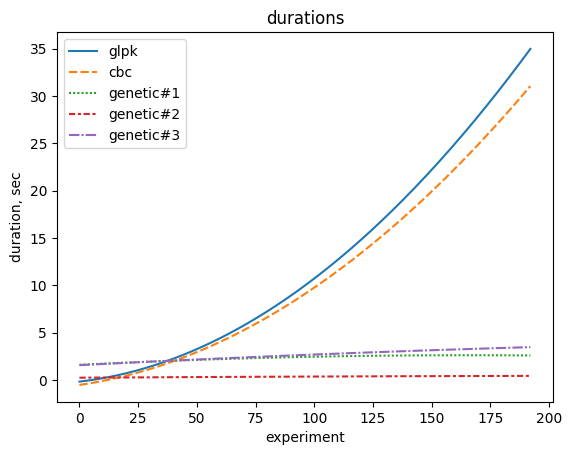

In [26]:
draw_durations_plot(polyfit_durations_df)

In [ ]:
# как показывать качество работы?

# общую статистику среди решателей о том, 
# в скольких процентах экспериментов каждый из них был лучшим (можно единую круговую диаграмму)

# статистику по каждому из решателей в каком количестве экспериментов 